In [1]:
import os
import requests
import uuid
from io import BytesIO
import numpy as np
import pandas as pd
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

from sklearn.neighbors import NearestNeighbors

import tensorflow as tf
from keras.models import Model
from keras import layers
from keras.regularizers import l2
from keras.utils import Sequence

import matplotlib.pyplot as plt
import hashlib
import logging

# Configuración de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('smote_process.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

print(f'tensorflow: {tf.__version__}')
print(f'keras: {tf.keras.__version__}')

tensorflow: 2.17.0
keras: 3.6.0


In [2]:
# 1. Configuración inicial
LOCAL_IMAGE_PATH = './repo_dataset'
LOCAL_IMAGE_SYNT_PATH = './synthetic_data'
TARGET_SIZE = (224, 224)
TARGET_SIZE_CHANNEL = (224, 224, 3)
BATCH_SIZE = 32

# Columnas de clases
LABEL_COLUMNS = ['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']

#cargar csv y dividir en dev set y test set
#CSV_PATH = '.\mobilnet-multi-label-dev-test-50.csv'
CSV_PATH = './mobilnet-multi-label-train-40-60-planilla.csv'

CSV_PATH_DEV = './mobilnet-multi-label-dev-40-40-50-planilla.csv'
CSV_PATH_TEST = './mobilnet-multi-label-test-40-40-50-planilla.csv'

CSV_TRAIN = CSV_PATH

MODEL_NAME = 'mobilenetv3_classifier.v.15.keras'

In [3]:
# cargar las imagenes
def prepare_image(row, local_image_path, label_columns, target_size):
    # Preparar las etiquetas
    labels = row[label_columns].values.astype(int)
 
    try:
        # Cargar desde archivo local
        filename = row['filename']
        img_path = os.path.join(local_image_path, filename)
        if 'synth_' in filename:
           img_path = os.path.join(LOCAL_IMAGE_SYNT_PATH, filename)
           if os.path.exists(img_path):
                image = Image.open(img_path)
           else:
                #workaround
                img_path = os.path.join(LOCAL_IMAGE_SYNT_PATH, filename.replace('synth_', ''))
                image = Image.open(img_path)
        elif os.path.exists(img_path):
            image = Image.open(os.path.join(local_image_path, filename))
        elif pd.notna(row['urlAbsoluta']):    
             urlAbsoluta = row['urlAbsoluta']
             if 'http' in urlAbsoluta:
                 # Descargar la imagen desde la URL
                 response = requests.get(row['urlAbsoluta'], stream=True, timeout=10)
                 if response.status_code == 200:              
                     image = Image.open(BytesIO(response.content))
                     #guardar local para el siguiente ciclo de entrenamiento/prueba
                     image.save(img_path)
             elif os.path.exists(urlAbsoluta):
                 image = Image.open(urlAbsoluta)
             else:
                 raise Exception(f'Error cargando {urlAbsoluta}, archivo no encontrado')
    
        # Convertir a RGB (en caso de que la imagen esté en otro formato, como RGBA)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Redimensionar la imagen
        image = image.resize(target_size)  # Redimensionar a 224x224 para MobileNetV3
        
        # Convertir a un array de numpy y normalizar
        image = np.array(image) / 255.0  # Normalizar
        
        return image, np.array(labels)
    except BaseException as e:
        print(f'Error en: {img_path}, Excepción: {str(e)}')
        return None


In [4]:
# 1. Data Augmentation para robustecer el entrenamiento
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

def build_model(num_classes):
    # 1. Cargar el modelo base pre-entrenado (MobileNetV3Large) sin la capa de clasificación final
    base_model = tf.keras.applications.MobileNetV3Large(
        input_shape=TARGET_SIZE_CHANNEL,
        include_preprocessing=False, # las imagnes de entrada estan normalizadas [0,1] y el modelo espera [0,255]
        include_top=False,  # Excluimos la parte de clasificación original
        weights='imagenet'
    )
    base_model.trainable = False

    # Construir la nueva arquitectura agregando una cabeza de clasificación para multi-label
    inputs = tf.keras.Input(shape=TARGET_SIZE_CHANNEL)
    # Aplicar data augmentation PRIMERO (en [0,1])
    x = data_augmentation(inputs)
    
    # Luego normalizar a [-1,1]
    x = layers.Rescaling(scale=2.0, offset=-1.0)(x)  # Mapea [0,1] a [-1,1]

    # Pasar por la base pre-entrenada (no se necesita rescaling adicional)
    x = base_model(x, training=False)  # training=False mantiene fijos los parámetros de BatchNorm
    
    # Utilizar GlobalAveragePooling2D para aplanar la salida del base model
    x = layers.GlobalAveragePooling2D()(x)
    
    # CAPAS ADICIONALES:
    # Capa densa adicional para aprender representaciones más complejas
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    # Agregar capa densa con regularización L2, BatchNormalization y Dropout
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Capa de salida para multi-label con activación sigmoide
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    return Model(inputs, outputs)

In [5]:
# calcular frecuencias de las clases del set de entrenamiento antes de smote
def print_class_distribution_from_csv_no_SMOTE(csv_path, label_columns):
    """
    Imprime la distribución de clases leyendo desde un archivo CSV
    
    Parámetros:
    csv_path: str - Ruta al archivo CSV
    label_columns: list - Lista de nombres de las columnas de etiquetas
    """
    # Leer solo las columnas necesarias del CSV
    df = pd.read_csv(csv_path)
    df = df[df['filename'].str.startswith('synth_')==False]
    total_samples = len(df)
    frecuencias = [0] * len(label_columns)
    
    print(f"Dataset preparado con {total_samples} imágenes sin SOMTE")
    print(f"Distribución de clases sin SMOTE:")
    
    for idx, col in enumerate(label_columns):
        positive_samples = df[col].sum()
        percentage = (positive_samples / total_samples) * 100
        print(f"{col}: {percentage:.2f}% ({int(positive_samples)}/{total_samples})")
        frecuencias[idx] = positive_samples
    return total_samples, frecuencias

total_samples, frecuencias = print_class_distribution_from_csv_no_SMOTE(CSV_TRAIN, LABEL_COLUMNS)
print(total_samples, frecuencias)
alpha = [n / total_samples for n in frecuencias]  
alpha = [1 - n for n in alpha]  
print(f'frecuencia={frecuencias}, alpha={alpha}')


Dataset preparado con 3963 imágenes sin SOMTE
Distribución de clases sin SMOTE:
direccion: 16.20% (642/3963)
fachada: 17.54% (695/3963)
envio: 53.65% (2126/3963)
etiqueta: 37.50% (1486/3963)
planilla: 18.67% (740/3963)
3963 [642, 695, 2126, 1486, 740]
frecuencia=[642, 695, 2126, 1486, 740], alpha=[0.838001514004542, 0.824627807216755, 0.46353772394650516, 0.6250315417612919, 0.8132727731516528]


In [6]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Aplicamos el umbral a las predicciones
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))
        
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)
    
    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


class F1ScoreMacro(tf.keras.metrics.Metric):
    def __init__(self, num_classes, threshold=0.5, name='f1_macro', **kwargs):
        super(F1ScoreMacro, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.threshold = threshold
        self.f1_per_class = [F1Score(threshold=threshold) for _ in range(num_classes)]

    def update_state(self, y_true, y_pred, sample_weight=None):
        for i in range(self.num_classes):
            self.f1_per_class[i].update_state(y_true[:, i], y_pred[:, i], sample_weight)

    def result(self):
        return tf.reduce_mean([f1.result() for f1 in self.f1_per_class])

    def reset_state(self):
        for f1 in self.f1_per_class:
            f1.reset_state()

class F1ScoreMicro(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, name='f1_micro', **kwargs):
        super(F1ScoreMicro, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


In [7]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, img_size, local_image_path, label_columns, shuffle=True, **kwargs):
        # Llamada al constructor de la clase base
        super().__init__(**kwargs)
        
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.dataframe))
        self.on_epoch_end()
        self.local_image_path = local_image_path
        self.label_columns = label_columns
        
    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))
    
    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.dataframe))
        batch_indices = self.indices[start:end]
        batch_data = self.dataframe.iloc[batch_indices]
        
        images = []
        labels = []
        
        for _, row in batch_data.iterrows():
            result = prepare_image(row, self.local_image_path, self.label_columns, self.img_size)
            # Ya sabemos que prepare_image debería retornar datos válidos porque se filtró
            if result is not None:
                img, label = result
                images.append(img)
                labels.append(label)
            else:
                print('Omitiendo imagen inesperadamente:', row['filename'])
                continue
        
        X, y = np.array(images), np.array(labels)        
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [8]:
class KFoldDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_paths, labels, batch_size=32, shuffle=True, **kwargs):
        # Llamada al constructor de la clase base
        super().__init__(**kwargs)
        
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # Usamos ceil para cubrir todos los ejemplos, incluso si el total no es múltiplo exacto de batch_size
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # Índices del batch actual
        batch_indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        labels_batch = []
        for i in batch_indexes:
            columnas = ['filename', 'urlAbsoluta', 'direccion', 'fachada', 'envio', 'etiqueta', 'planilla']
            df = pd.DataFrame(columns=columnas)
            new_row = {
                'filename': self.file_paths[i],
                'urlAbsoluta': '',
                'direccion': self.labels[i][0],
                'fachada': self.labels[i][1],
                'envio': self.labels[i][2],
                'etiqueta': self.labels[i][3],
                'planilla': self.labels[i][4]
            }
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
            ultima_fila = df.loc[len(df) - 1]
            result = prepare_image(ultima_fila, LOCAL_IMAGE_PATH, LABEL_COLUMNS, TARGET_SIZE)

            if result is not None:
                image, _ = result
                images.append(image)
                labels_batch.append(self.labels[i])
            else: 
                continue
        
        # Convertir la lista de imágenes a un tensor (batch, 224, 224, 3)
        X = tf.stack(images)
        Y = tf.convert_to_tensor(labels_batch, dtype=tf.float32)
        return X, Y

Estadísticas de datos:
Dataset de entrenamiento - Total: 5899, Reales: 3963 (0.6718087811493474), Sintéticos: 1936 (0.32819121885065267)
Dataset de validación: 1291 muestras
Dataset de prueba: 1319 muestras
loss...
loss OK

===== Fold 1 / 5 =====
<class 'keras.src.models.functional.Functional'>
Fase 1: Entrenamiento con base congelada
Epoch 1/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 427s 3s/step - f1_macro: 0.7238 - f1_micro: 0.7224 - loss: 1.1531 - val_f1_macro: 0.8573 - val_f1_micro: 0.8744 - val_loss: 0.7861
Epoch 2/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 424s 3s/step - f1_macro: 0.8308 - f1_micro: 0.8275 - loss: 0.7367 - val_f1_macro: 0.8744 - val_f1_micro: 0.8868 - val_loss: 0.5205
Epoch 3/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - f1_macro: 0.8565 - f1_micro: 0.8537 - loss: 0.4807 - val_f1_macro: 0.8548 - val_f1_micro: 0.8778 - val_loss: 0.3477
Epoch 4/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - f1_macro: 0.8712 - f1_micro: 0.8696 - loss: 0.3218 - val_f1_macro: 0.8762 - val_f1_micro: 0.8862 - 

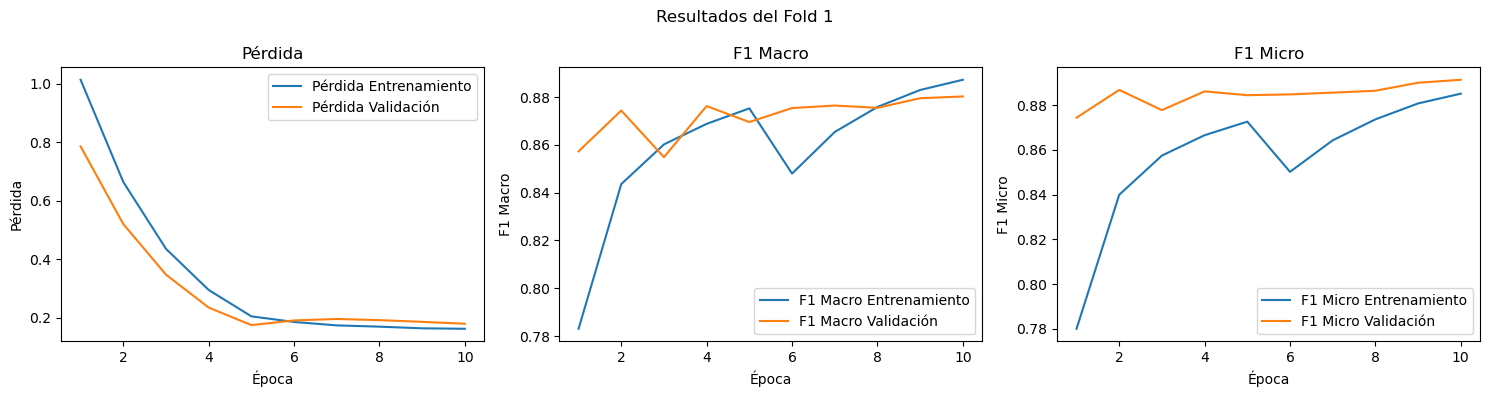


===== Fold 2 / 5 =====
<class 'keras.src.models.functional.Functional'>
Fase 1: Entrenamiento con base congelada
Epoch 1/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 420s 3s/step - f1_macro: 0.7940 - f1_micro: 0.7993 - loss: 1.1390 - val_f1_macro: 0.8443 - val_f1_micro: 0.8615 - val_loss: 0.7850
Epoch 2/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 422s 3s/step - f1_macro: 0.8388 - f1_micro: 0.8345 - loss: 0.7178 - val_f1_macro: 0.8609 - val_f1_micro: 0.8819 - val_loss: 0.5036
Epoch 3/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 413s 3s/step - f1_macro: 0.8596 - f1_micro: 0.8573 - loss: 0.4643 - val_f1_macro: 0.8663 - val_f1_micro: 0.8862 - val_loss: 0.3277
Epoch 4/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 423s 3s/step - f1_macro: 0.8743 - f1_micro: 0.8734 - loss: 0.3043 - val_f1_macro: 0.8684 - val_f1_micro: 0.8851 - val_loss: 0.2242
Epoch 5/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 412s 3s/step - f1_macro: 0.8761 - f1_micro: 0.8741 - loss: 0.2082 - val_f1_macro: 0.8621 - val_f1_micro: 0.8834 - val_loss: 0.1612
Fase 2: Fine-tuning descongelando la

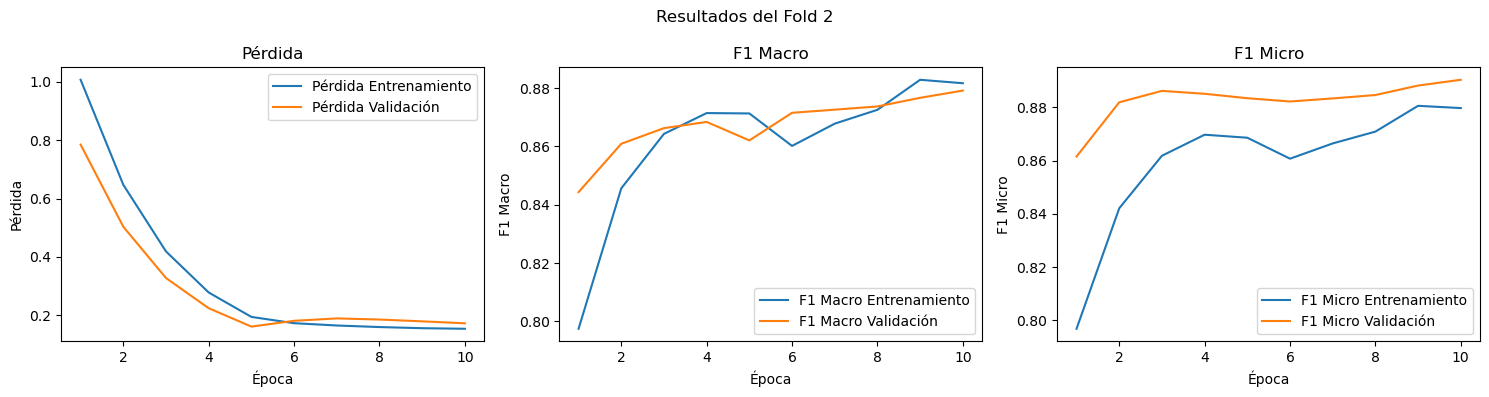


===== Fold 3 / 5 =====
<class 'keras.src.models.functional.Functional'>
Fase 1: Entrenamiento con base congelada
Epoch 1/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - f1_macro: 0.7833 - f1_micro: 0.7896 - loss: 1.1649 - val_f1_macro: 0.8702 - val_f1_micro: 0.8786 - val_loss: 0.8022
Epoch 2/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 412s 3s/step - f1_macro: 0.8364 - f1_micro: 0.8335 - loss: 0.7432 - val_f1_macro: 0.8582 - val_f1_micro: 0.8713 - val_loss: 0.5298
Epoch 3/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - f1_macro: 0.8495 - f1_micro: 0.8481 - loss: 0.4938 - val_f1_macro: 0.8642 - val_f1_micro: 0.8756 - val_loss: 0.3538
Epoch 4/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 432s 3s/step - f1_macro: 0.8699 - f1_micro: 0.8682 - loss: 0.3273 - val_f1_macro: 0.8673 - val_f1_micro: 0.8841 - val_loss: 0.2381
Epoch 5/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 414s 3s/step - f1_macro: 0.8686 - f1_micro: 0.8680 - loss: 0.2286 - val_f1_macro: 0.8722 - val_f1_micro: 0.8853 - val_loss: 0.1736
Fase 2: Fine-tuning descongelando la

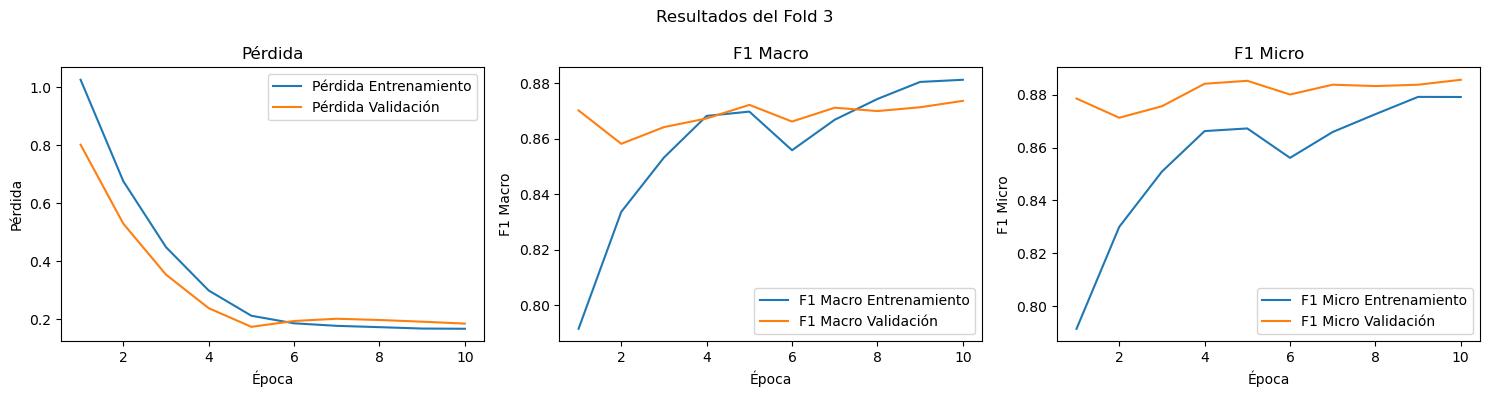


===== Fold 4 / 5 =====
<class 'keras.src.models.functional.Functional'>
Fase 1: Entrenamiento con base congelada
Epoch 1/5
  7/148 ━━━━━━━━━━━━━━━━━━━━ 6:07 3s/step - f1_macro: 0.8249 - f1_micro: 0.8423 - loss: 1.4786  

In [ ]:
# K-fold cross validation
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Dataset de entrenamiento (contiene datos sintéticos)
csv_path_train = CSV_TRAIN
df_train = pd.read_csv(csv_path_train)

# Dataset de validación (sin datos sintéticos)
csv_path_dev = CSV_PATH_DEV
df_dev = pd.read_csv(csv_path_dev)

# Dataset de prueba (sin datos sintéticos)
csv_path_test = CSV_PATH_TEST
df_test = pd.read_csv(csv_path_test)

# Filtrar datos sintéticos del conjunto de entrenamiento
# Asumiendo que podemos identificar datos sintéticos en el nombre del archivo
# Adaptarlo según el método que usas para identificar datos sintéticos
df_train_real = df_train[df_train['filename'].str.startswith('synth_')==False]

print('Estadísticas de datos:')
total_train = len(df_train)
train_real = len(df_train_real)
print(f'Dataset de entrenamiento - Total: {total_train}, Reales: {train_real} ({train_real/total_train}), Sintéticos: {total_train - train_real} ({(total_train - train_real)/total_train})')
print(f'Dataset de validación: {len(df_dev)} muestras')
print(f'Dataset de prueba: {len(df_test)} muestras')

# Para el K-fold, solo usaremos los datos reales del conjunto de entrenamiento
file_paths_train = df_train['filename'].values
labels_train = df_train[LABEL_COLUMNS].values.astype(np.float32)

dev_file_paths = df_dev['filename'].values
dev_labels = df_dev[LABEL_COLUMNS].values.astype(np.float32)

# Parámetros
k_splits = 5
batch_size = BATCH_SIZE
initial_epochs = 5
finetune_epochs = 5   # Fase 2: fine-tuning (descongelar últimas 20 capas)
input_shape = TARGET_SIZE_CHANNEL
num_classes = len(LABEL_COLUMNS)

print('loss...')
loss_fn = tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, alpha=alpha)
print('loss OK')

# Optimizador con learning rate adaptativo
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

num_classes = len(LABEL_COLUMNS)
# F1-score macro promedia la F1 de cada clase.
f1_macro = F1ScoreMacro(num_classes=num_classes, threshold=0.5)

# F1-score micro calcula la F1 global (acumulando TP, FP, FN de todas las clases).
f1_micro = F1ScoreMicro(threshold=0.5)


kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)
fold_no = 1
best_val_loss = np.inf  # Para guardar el mejor modelo
final_model = None      # Para almacenar el modelo final
histories = []          # Para almacenar history de cada fold (opcional)

for train_idx, val_idx in kf.split(file_paths_train):
    print(f'\n===== Fold {fold_no} / {k_splits} =====')
    train_paths, train_labels = file_paths_train[train_idx], labels_train[train_idx]
    
    # Para validación, se utiliza todo el CSV de validación (solo datos reales)
    val_paths, val_labels = dev_file_paths, dev_labels
    
    # Crear generadores
    train_gen = KFoldDataGenerator(train_paths, train_labels, batch_size=batch_size, shuffle=True)
    val_gen = KFoldDataGenerator(val_paths, val_labels, batch_size=batch_size, shuffle=False)
    
    
    # --- Fase 1: Entrenamiento con la base congelada ---
    model = build_model(num_classes=len(LABEL_COLUMNS))
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, alpha=alpha),
        metrics=[f1_macro, f1_micro]
    )   

    print(type(model))

    
    print('Fase 1: Entrenamiento con base congelada')
    history1 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=initial_epochs,
        verbose=1
    )
    
    # --- Fase 2: Fine-Tuning ---
    # Descongelar las últimas 20 capas del modelo base
    base_model = model.get_layer('MobileNetV3Large') # Índice de la capa MobileNetV3
    # En algunos casos, es mejor usar el nombre. Por ejemplo:
    # base_model = model.get_layer('mobilenetv3large')
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, alpha=alpha),
        metrics=[f1_macro, f1_micro]
    )
    
    print('Fase 2: Fine-tuning descongelando las últimas 20 capas')
    history2 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=finetune_epochs,
        verbose=1
    )
    
    # Combinar histories (opcional, para graficar)
    history_combined = {}
    for key in history1.history.keys():
        history_combined[key] = history1.history[key] + history2.history[key]
    histories.append(history_combined)
    
    # Evaluar el modelo en el conjunto de validación
    scores = model.evaluate(val_gen, verbose=0)
    print(f"Resultados fold {fold_no}: {model.metrics_names} = {scores}")
    
    # Guardar el modelo si obtuvo menor pérdida de validación
    val_loss = scores[model.metrics_names.index('loss')]
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        final_model = model  # Se guarda el modelo con la mejor pérdida de validación
        model.save(MODEL_NAME)
        print(f"Nuevo mejor modelo guardado (fold {fold_no})")
    
    # Graficar la evolución de las métricas de este fold
    epochs_total = initial_epochs + finetune_epochs
    plt.figure(figsize=(15, 4))
    
    # Pérdida
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs_total+1), history_combined['loss'], label='Pérdida Entrenamiento')
    plt.plot(range(1, epochs_total+1), history_combined['val_loss'], label='Pérdida Validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Pérdida')
    plt.legend()
    
    # F1 Macro
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs_total+1), history_combined['f1_macro'], label='F1 Macro Entrenamiento')
    plt.plot(range(1, epochs_total+1), history_combined['val_f1_macro'], label='F1 Macro Validación')
    plt.xlabel('Época')
    plt.ylabel('F1 Macro')
    plt.title('F1 Macro')
    plt.legend()
    
    # F1 Micro
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs_total+1), history_combined['f1_micro'], label='F1 Micro Entrenamiento')
    plt.plot(range(1, epochs_total+1), history_combined['val_f1_micro'], label='F1 Micro Validación')
    plt.xlabel('Época')
    plt.ylabel('F1 Micro')
    plt.title('F1 Micro')
    plt.legend()
    
    plt.suptitle(f"Resultados del Fold {fold_no}")
    plt.tight_layout()
    plt.show()
    
    fold_no += 1

# Mostrar resultados promedio (por ejemplo, promedio de la pérdida de validación)
# (Aquí se puede agregar cálculo de promedios si se almacenan los scores de cada fold)
print(f'\nProceso de K-Fold completado. El mejor modelo se guardó como {MODEL_NAME}.')

# PASO FINAL: Evaluar el mejor modelo en el conjunto de test real
# Preparar el generador para el conjunto de test
csv_path_test = CSV_PATH_TEST 
df_test = pd.read_csv(csv_path_test)
test_paths = df_test['filename'].values
test_labels = df_test[LABEL_COLUMNS].values.astype(np.float32)
test_gen = KFoldDataGenerator(test_paths, test_labels, batch_size=batch_size, shuffle=False)

# Evaluar el mejor modelo en el conjunto de test
print('\n===== Evaluación final en el conjunto de TEST =====')
test_scores = final_model.evaluate(test_gen, verbose=1)
print(f'Rendimiento en test: {final_model.metrics_names} = {test_scores}')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         492,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,782,833 (25.87 MB)

 Trainable params: 1,579,381 (6.02 MB)

 Non-trainable params: 2,044,688 (7.80 MB)

 Optimizer params: 3,158,764 (12.05 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

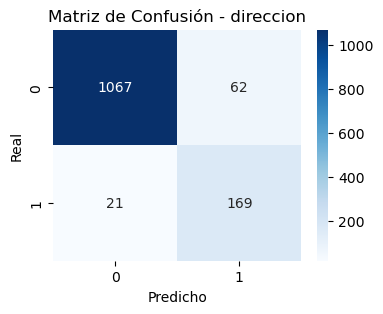

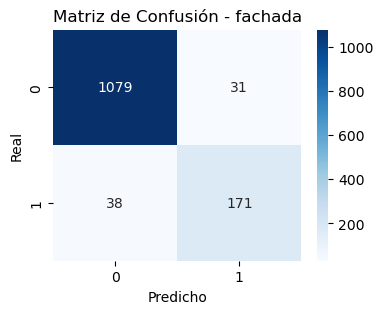

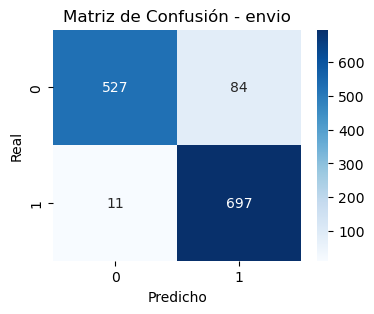

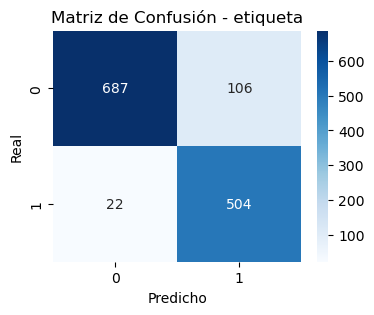

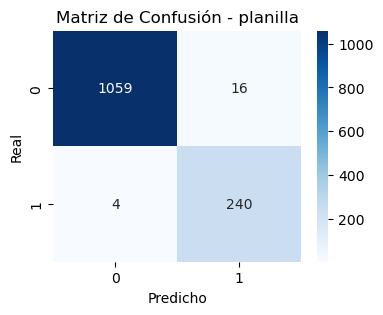

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import load_model

# Supongamos que tienes el conjunto de validación como un data generator
# y_true_total y y_pred_total se obtienen acumulando las etiquetas verdaderas y las predichas.

y_true_total = []
y_pred_total = []

val_df = pd.read_csv(CSV_PATH_TEST)
val_gen = CustomDataGenerator(val_df, BATCH_SIZE, TARGET_SIZE, LOCAL_IMAGE_PATH, label_columns=LABEL_COLUMNS, shuffle=False)
model = load_model(MODEL_NAME, 
                   custom_objects={
                       'F1ScoreMacro': lambda **kwargs: F1ScoreMacro(num_classes=len(LABEL_COLUMNS), threshold=0.5, **kwargs),
                       'F1ScoreMicro': lambda **kwargs: F1ScoreMicro(threshold=0.5, **kwargs)
    })
model.summary()

for i in range(len(val_gen)):
    X_batch, y_batch = val_gen[i]
    preds = model.predict(X_batch)
    y_true_total.append(y_batch)
    y_pred_total.append(preds)
    
    
print('generando...')
# Convertir a arrays
y_true_total = np.vstack(y_true_total)
y_pred_total = np.vstack(y_pred_total)

# Aplicar umbral para obtener predicciones binarias
threshold = 0.5
y_pred_binary = (y_pred_total > threshold).astype(int)

# Ahora, para cada clase, calculamos y graficamos la matriz de confusión
num_classes = y_true_total.shape[1]

for i in range(num_classes):
    cm = confusion_matrix(y_true_total[:, i], y_pred_binary[:, i])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {LABEL_COLUMNS[i]}')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show()


-->> Row 0: filename                 800218511400610067_2025030321035618.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 0, dtype: object
img_path: ./repo_validation\800218511400610067_2025030321035618.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
0 : Predicciones (probabilidades): [[0.10298495 0.11369697 0.04467501 0.06480839 0.05788579]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


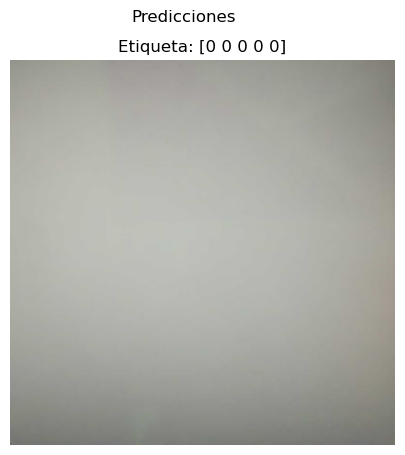

Etiquetas predichas: [[0 0 0 0 0]]


-->> Row 1: filename                 800218511400610067_2025030321035613.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 1, dtype: object
img_path: ./repo_validation\800218511400610067_2025030321035613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1 : Predicciones (probabilidades): [[0.04262281 0.05775097 0.767897   0.9719395  0.1210259 ]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


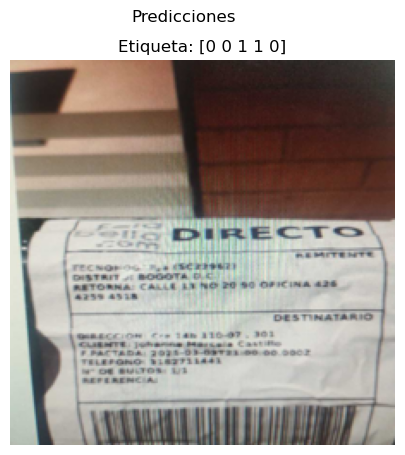

Etiquetas predichas: [[0 0 1 1 0]]


-->> Row 2: filename                        12763821181_2025030320051187.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 2, dtype: object
img_path: ./repo_validation\12763821181_2025030320051187.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2 : Predicciones (probabilidades): [[0.02690669 0.03637373 0.8544665  0.9711333  0.09453516]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


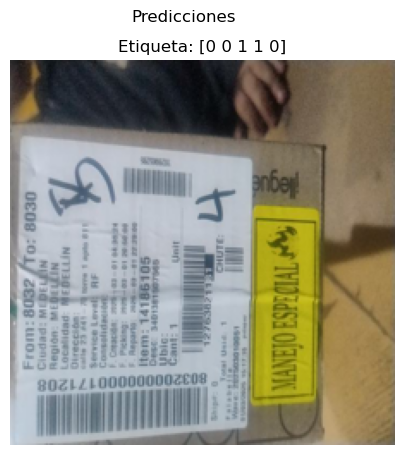

Etiquetas predichas: [[0 0 1 1 0]]


-->> Row 3: filename                 800218511413640229_2025030320012886.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 3, dtype: object
img_path: ./repo_validation\800218511413640229_2025030320012886.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
3 : Predicciones (probabilidades): [[0.63387406 0.52767515 0.21946053 0.20673369 0.0292675 ]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


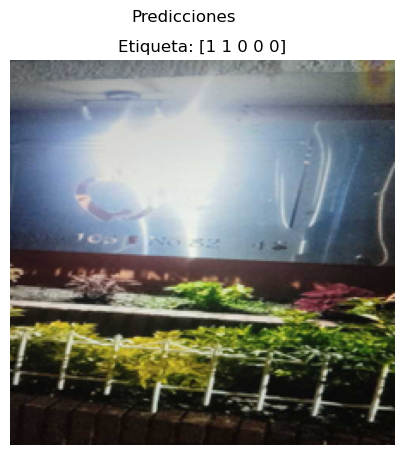

Etiquetas predichas: [[1 1 0 0 0]]


-->> Row 4: filename                        12763789450_2025030319591758.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 4, dtype: object
img_path: ./repo_validation\12763789450_2025030319591758.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4 : Predicciones (probabilidades): [[0.38454315 0.272156   0.00709116 0.01263721 0.9513638 ]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


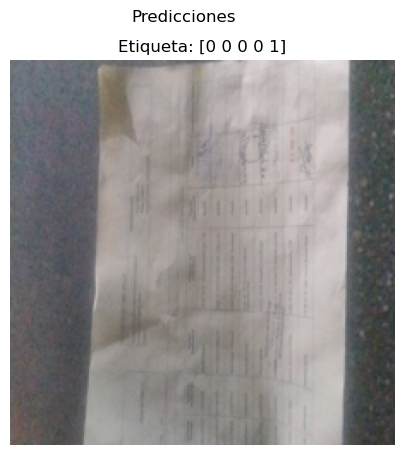

Etiquetas predichas: [[0 0 0 0 1]]


-->> Row 5: filename                        12763789450_2025030319591753.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 5, dtype: object
img_path: ./repo_validation\12763789450_2025030319591753.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
5 : Predicciones (probabilidades): [[0.4723355  0.60455054 0.42226896 0.1215092  0.0460082 ]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


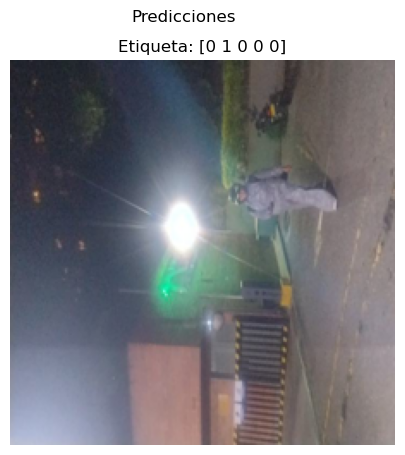

Etiquetas predichas: [[0 1 0 0 0]]


-->> Row 6: filename                        12763789450_2025030319591748.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 6, dtype: object
img_path: ./repo_validation\12763789450_2025030319591748.jpg
urlAbsoluta: https://stlogimasest2prod.blob.core.windows.net/lcstacc/2025/03/12763789450_2025030319591748.jpg
Error en: ./repo_validation\12763789450_2025030319591748.jpg, Excepción: cannot write mode RGBA as JPEG
-->> Row 7: filename                        12763789450_2025030319591740.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 7, dtype: object
img_path: ./repo_validation\12763789450_2025030319591740.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
7 : Predicciones (probabilidades): [[0.09273048 0.2474496  0.91853046 0.25378698 0.03953903]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


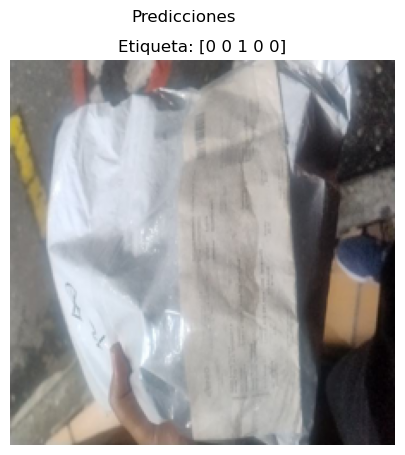

Etiquetas predichas: [[0 0 1 0 0]]


-->> Row 8: filename                        12763789467_2025030319584280.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 8, dtype: object
img_path: ./repo_validation\12763789467_2025030319584280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8 : Predicciones (probabilidades): [[0.5288662  0.6586388  0.3504059  0.23746946 0.08168759]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


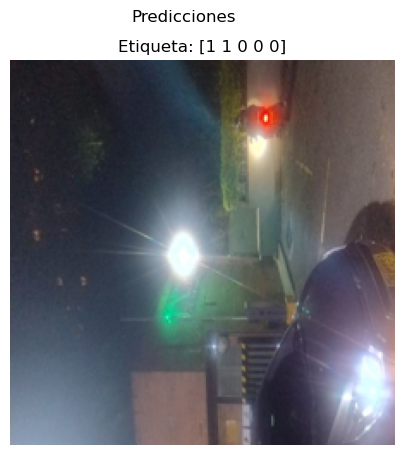

Etiquetas predichas: [[1 1 0 0 0]]


-->> Row 9: filename                        12763789467_2025030319584275.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 9, dtype: object
img_path: ./repo_validation\12763789467_2025030319584275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
9 : Predicciones (probabilidades): [[0.13144808 0.12285928 0.0365343  0.04423854 0.9956677 ]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


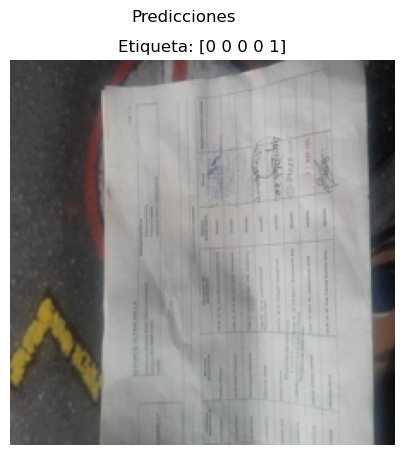

Etiquetas predichas: [[0 0 0 0 1]]


-->> Row 10: filename                        12763789467_2025030319584269.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 10, dtype: object
img_path: ./repo_validation\12763789467_2025030319584269.jpg
urlAbsoluta: https://stlogimasest2prod.blob.core.windows.net/lcstacc/2025/03/12763789467_2025030319584269.jpg
Error en: ./repo_validation\12763789467_2025030319584269.jpg, Excepción: cannot write mode RGBA as JPEG
-->> Row 11: filename                        12763789467_2025030319584259.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 11, dtype: object
img_path: ./repo_validation\12763789467_2025030319584259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
11 : Predicciones (probabilidades): [[0.00763064 0.00446928 0.76467663 0.99002165 0.00487086]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


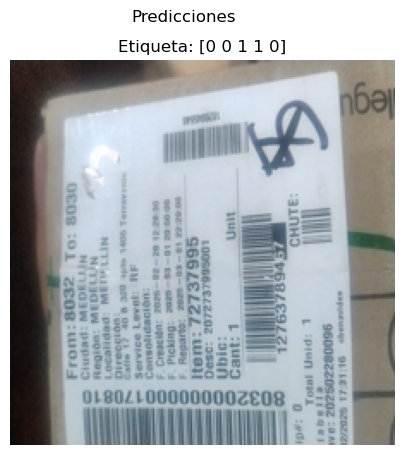

Etiquetas predichas: [[0 0 1 1 0]]


-->> Row 12: filename                 800042211358714346_2025030319523536.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 12, dtype: object
img_path: ./repo_validation\800042211358714346_2025030319523536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
12 : Predicciones (probabilidades): [[0.5831553  0.6869459  0.07899854 0.07490972 0.01710442]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


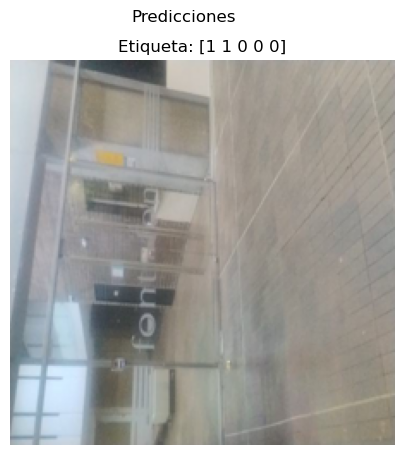

Etiquetas predichas: [[1 1 0 0 0]]


-->> Row 13: filename                 800042211358714346_2025030319523531.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 13, dtype: object
img_path: ./repo_validation\800042211358714346_2025030319523531.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
13 : Predicciones (probabilidades): [[0.02001088 0.02850944 0.00641547 0.01538912 0.99987704]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


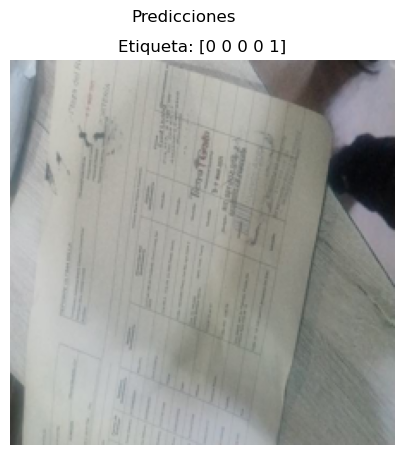

Etiquetas predichas: [[0 0 0 0 1]]


-->> Row 14: filename                 800042211358714346_2025030319523525.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 14, dtype: object
img_path: ./repo_validation\800042211358714346_2025030319523525.jpg
urlAbsoluta: https://stlogimasest2prod.blob.core.windows.net/lcstacc/2025/03/800042211358714346_2025030319523525.jpg
Error en: ./repo_validation\800042211358714346_2025030319523525.jpg, Excepción: cannot write mode RGBA as JPEG
-->> Row 15: filename                 800042211358714346_2025030319523512.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 15, dtype: object
img_path: ./repo_validation\800042211358714346_2025030319523512.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
15 : Predicciones (probabilidades): [[0.21544832 0.1057352  0.7017025  0.93457896 0.12286465]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


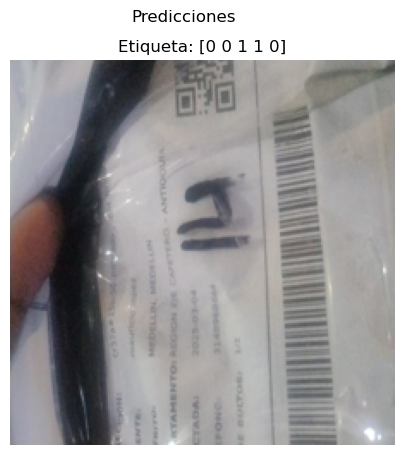

Etiquetas predichas: [[0 0 1 1 0]]


-->> Row 16: filename                 800218511399040041_2025030319511015.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 16, dtype: object
img_path: ./repo_validation\800218511399040041_2025030319511015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
16 : Predicciones (probabilidades): [[0.02075242 0.01544152 0.8023167  0.98538834 0.0331012 ]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


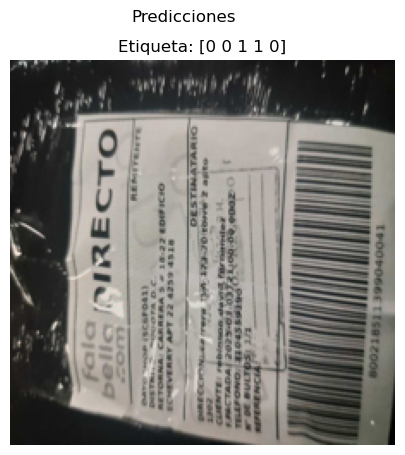

Etiquetas predichas: [[0 0 1 1 0]]


-->> Row 17: filename                 800218511399040041_2025030319511010.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 17, dtype: object
img_path: ./repo_validation\800218511399040041_2025030319511010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
17 : Predicciones (probabilidades): [[0.514012   0.49024442 0.34263375 0.18231809 0.06060191]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


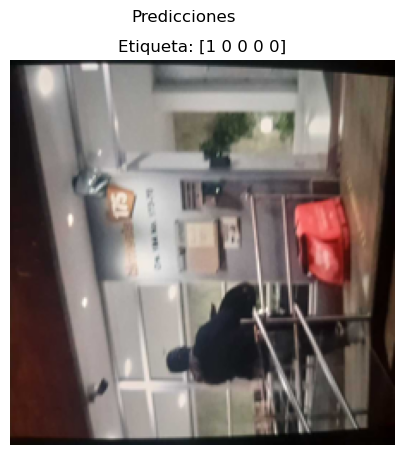

Etiquetas predichas: [[1 0 0 0 0]]


-->> Row 18: filename                 800218511399040041_2025030319511003.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 18, dtype: object
img_path: ./repo_validation\800218511399040041_2025030319511003.jpg
urlAbsoluta: https://stlogimasest2prod.blob.core.windows.net/lcstacc/2025/03/800218511399040041_2025030319511003.jpg
Error en: ./repo_validation\800218511399040041_2025030319511003.jpg, Excepción: cannot write mode RGBA as JPEG
-->> Row 19: filename                 800218511399040041_2025030319510990.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 19, dtype: object
img_path: ./repo_validation\800218511399040041_2025030319510990.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
19 : Predicciones (probabilidades): [[0.03406281 0.03075041 0.7347155  0.9807255  0.04371719]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


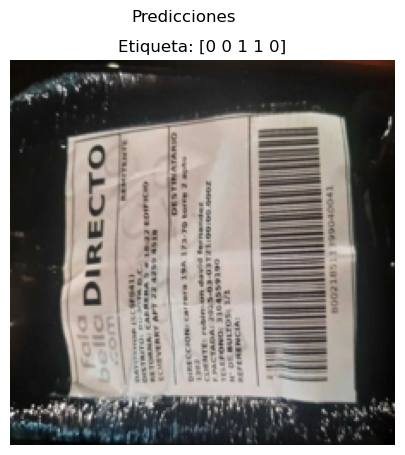

Etiquetas predichas: [[0 0 1 1 0]]


-->> Row 20: filename                 800129011402090123_2025030319414831.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 20, dtype: object
img_path: ./repo_validation\800129011402090123_2025030319414831.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
20 : Predicciones (probabilidades): [[0.02020058 0.02488933 0.9241251  0.86130995 0.01858983]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


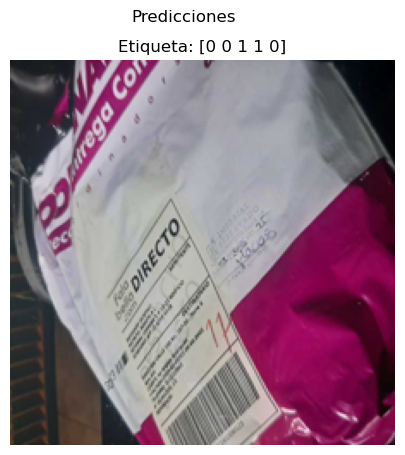

Etiquetas predichas: [[0 0 1 1 0]]


-->> Row 21: filename                 800129011402090123_2025030319414826.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 21, dtype: object
img_path: ./repo_validation\800129011402090123_2025030319414826.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
21 : Predicciones (probabilidades): [[0.8519751  0.62043214 0.03286624 0.0840488  0.02446885]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


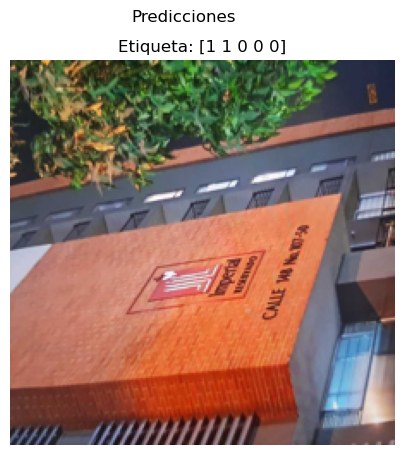

Etiquetas predichas: [[1 1 0 0 0]]


-->> Row 22: filename                 800129011402090123_2025030319414822.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 22, dtype: object
img_path: ./repo_validation\800129011402090123_2025030319414822.jpg
urlAbsoluta: https://stlogimasest2prod.blob.core.windows.net/lcstacc/2025/03/800129011402090123_2025030319414822.jpg
Error en: ./repo_validation\800129011402090123_2025030319414822.jpg, Excepción: cannot write mode RGBA as JPEG
-->> Row 23: filename                 800129011402090123_2025030319414812.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 23, dtype: object
img_path: ./repo_validation\800129011402090123_2025030319414812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
23 : Predicciones (probabilidades): [[0.04662608 0.06434304 0.8651121  0.7876156  0.01326118]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


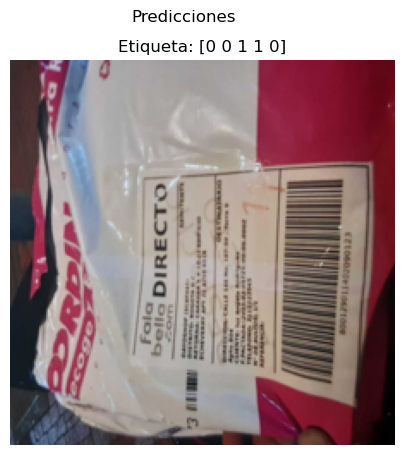

Etiquetas predichas: [[0 0 1 1 0]]


-->> Row 24: filename                 800129011413490271_2025030319414527.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 24, dtype: object
img_path: ./repo_validation\800129011413490271_2025030319414527.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
24 : Predicciones (probabilidades): [[0.07080705 0.01552255 0.10096732 0.32873988 0.8312125 ]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


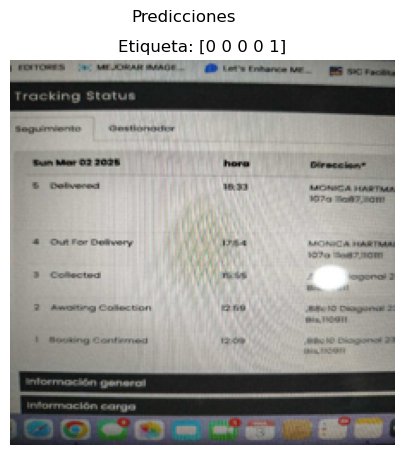

Etiquetas predichas: [[0 0 0 0 1]]


-->> Row 25: filename                 800129011413490271_2025030319414523.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 25, dtype: object
img_path: ./repo_validation\800129011413490271_2025030319414523.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
25 : Predicciones (probabilidades): [[0.15527764 0.04499521 0.14134601 0.3909778  0.8297413 ]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


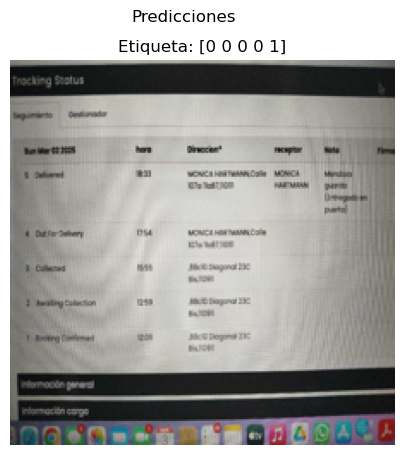

Etiquetas predichas: [[0 0 0 0 1]]


-->> Row 26: filename                 800129011413490271_2025030319414513.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 26, dtype: object
img_path: ./repo_validation\800129011413490271_2025030319414513.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
26 : Predicciones (probabilidades): [[0.6835958  0.4405418  0.41407368 0.33892098 0.18209158]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


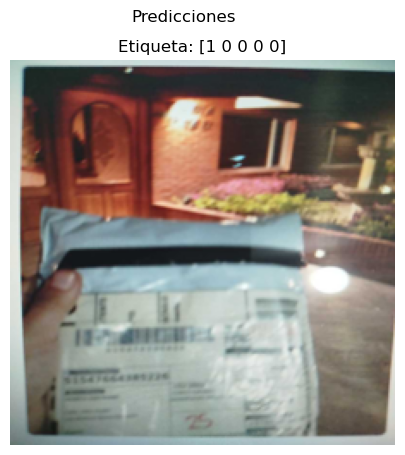

Etiquetas predichas: [[1 0 0 0 0]]


-->> Row 27: filename                 800053311344461325_2025030319405279.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 27, dtype: object
img_path: ./repo_validation\800053311344461325_2025030319405279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
27 : Predicciones (probabilidades): [[0.02953176 0.0445748  0.004746   0.00766764 0.9999582 ]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


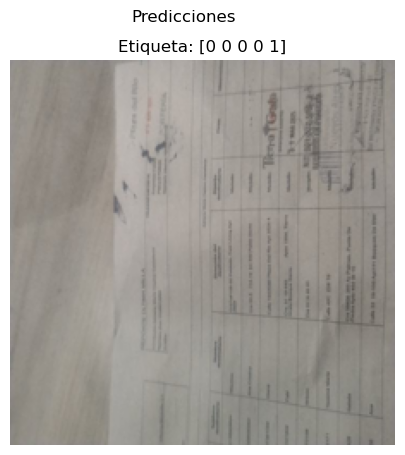

Etiquetas predichas: [[0 0 0 0 1]]


-->> Row 28: filename                 800053311344461325_2025030319405275.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 28, dtype: object
img_path: ./repo_validation\800053311344461325_2025030319405275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
28 : Predicciones (probabilidades): [[0.43678644 0.8393239  0.12929532 0.09259103 0.03150722]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


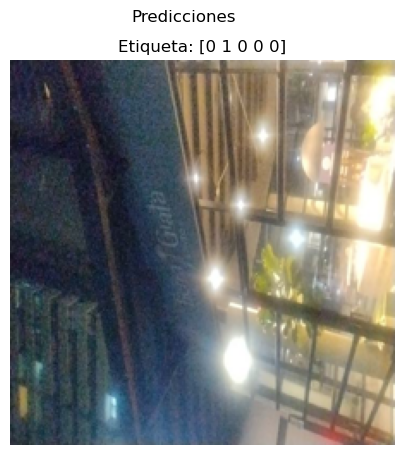

Etiquetas predichas: [[0 1 0 0 0]]


-->> Row 29: filename                 800053311344461325_2025030319405270.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 29, dtype: object
img_path: ./repo_validation\800053311344461325_2025030319405270.jpg
urlAbsoluta: https://stlogimasest2prod.blob.core.windows.net/lcstacc/2025/03/800053311344461325_2025030319405270.jpg
Error en: ./repo_validation\800053311344461325_2025030319405270.jpg, Excepción: cannot write mode RGBA as JPEG
-->> Row 30: filename                 800053311344461325_2025030319405258.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 30, dtype: object
img_path: ./repo_validation\800053311344461325_2025030319405258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
30 : Predicciones (probabilidades): [[0.20877811 0.14472415 0.7630669  0.83046126 0.06644731]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


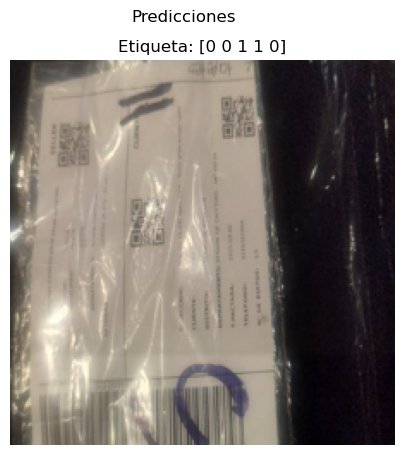

Etiquetas predichas: [[0 0 1 1 0]]


-->> Row 31: filename                 800090611390651250_2025030319393848.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 31, dtype: object
img_path: ./repo_validation\800090611390651250_2025030319393848.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
31 : Predicciones (probabilidades): [[0.8095591  0.62657154 0.05469961 0.06201218 0.01777322]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


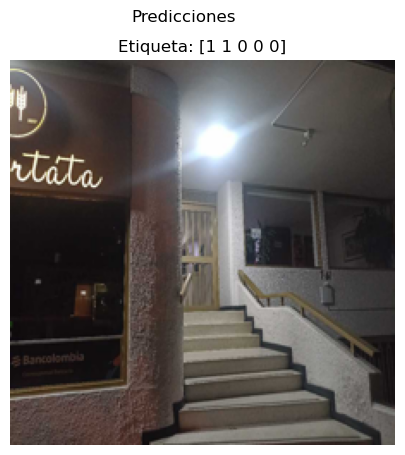

Etiquetas predichas: [[1 1 0 0 0]]


-->> Row 32: filename                 800090611390651250_2025030319393844.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 32, dtype: object
img_path: ./repo_validation\800090611390651250_2025030319393844.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32 : Predicciones (probabilidades): [[0.5921837  0.6876348  0.18260959 0.08389819 0.02845757]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


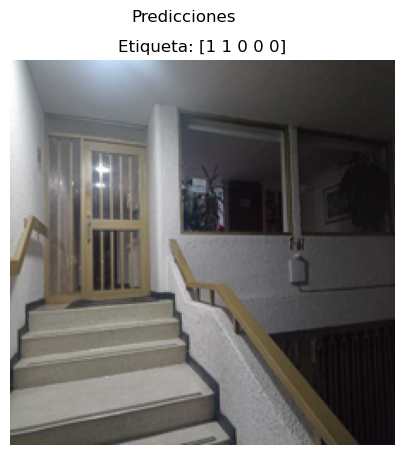

Etiquetas predichas: [[1 1 0 0 0]]


-->> Row 33: filename                 800090611390651250_2025030319393830.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 33, dtype: object
img_path: ./repo_validation\800090611390651250_2025030319393830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
33 : Predicciones (probabilidades): [[0.01213738 0.00918141 0.8456783  0.9820865  0.01665046]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


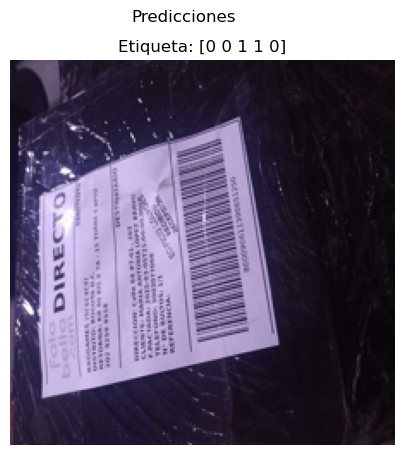

Etiquetas predichas: [[0 0 1 1 0]]


-->> Row 34: filename                 800000000000357029_2025030319311786.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 34, dtype: object
img_path: ./repo_validation\800000000000357029_2025030319311786.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
34 : Predicciones (probabilidades): [[0.46380076 0.65920204 0.18684672 0.10870529 0.17445032]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


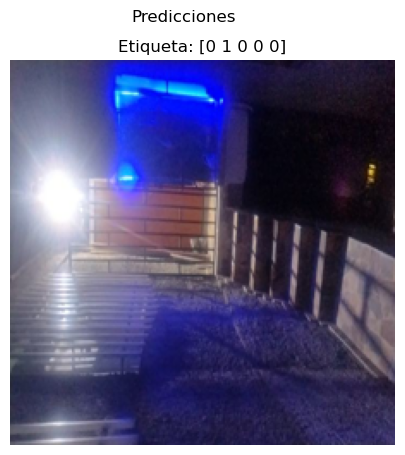

Etiquetas predichas: [[0 1 0 0 0]]


-->> Row 35: filename                 800000000000357029_2025030319311782.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 35, dtype: object
img_path: ./repo_validation\800000000000357029_2025030319311782.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
35 : Predicciones (probabilidades): [[0.05206348 0.06586578 0.00513518 0.00444685 0.9999083 ]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


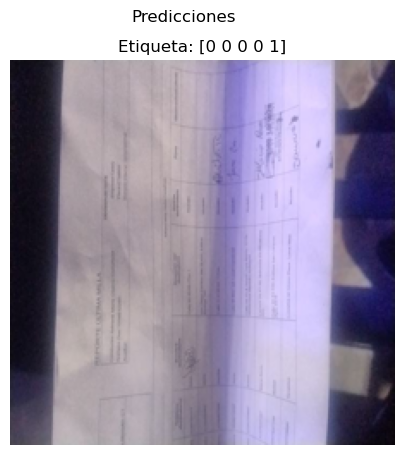

Etiquetas predichas: [[0 0 0 0 1]]


-->> Row 36: filename                 800000000000357029_2025030319311778.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 36, dtype: object
img_path: ./repo_validation\800000000000357029_2025030319311778.jpg
urlAbsoluta: https://stlogimasest2prod.blob.core.windows.net/lcstacc/2025/03/800000000000357029_2025030319311778.jpg
Error en: ./repo_validation\800000000000357029_2025030319311778.jpg, Excepción: cannot write mode RGBA as JPEG
-->> Row 37: filename                 800000000000357029_2025030319311767.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 37, dtype: object
img_path: ./repo_validation\800000000000357029_2025030319311767.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
37 : Predicciones (probabilidades): [[0.10600208 0.10022242 0.73271513 0.90574825 0.10491734]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


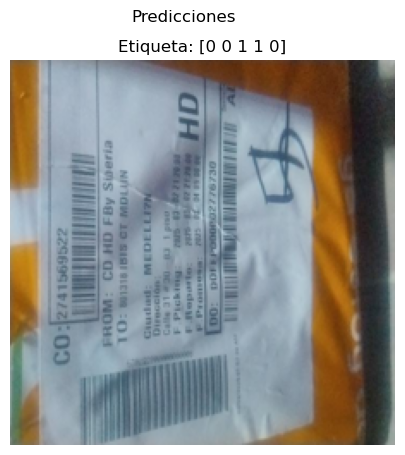

Etiquetas predichas: [[0 0 1 1 0]]


-->> Row 38: filename                        12763822621_2025030319280891.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 38, dtype: object
img_path: ./repo_validation\12763822621_2025030319280891.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
38 : Predicciones (probabilidades): [[0.7421061  0.6090664  0.05136893 0.08543191 0.11451662]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


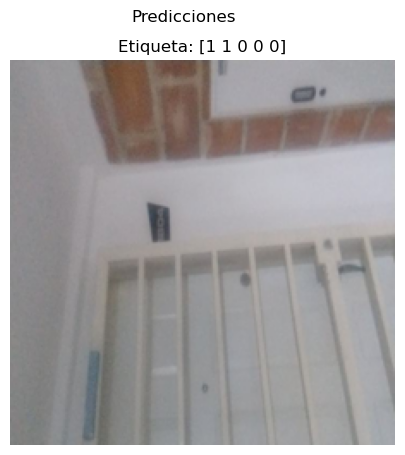

Etiquetas predichas: [[1 1 0 0 0]]


-->> Row 39: filename                        12763822621_2025030319280886.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 39, dtype: object
img_path: ./repo_validation\12763822621_2025030319280886.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
39 : Predicciones (probabilidades): [[0.02367535 0.06967685 0.01439854 0.01295854 0.9997166 ]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


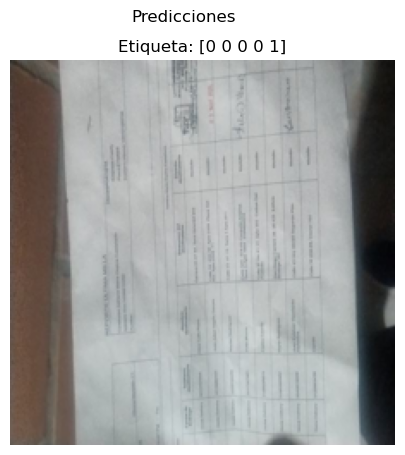

Etiquetas predichas: [[0 0 0 0 1]]


-->> Row 40: filename                        12763822621_2025030319280882.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 40, dtype: object
img_path: ./repo_validation\12763822621_2025030319280882.jpg
urlAbsoluta: https://stlogimasest2prod.blob.core.windows.net/lcstacc/2025/03/12763822621_2025030319280882.jpg
Error en: ./repo_validation\12763822621_2025030319280882.jpg, Excepción: cannot write mode RGBA as JPEG
-->> Row 41: filename                        12763822621_2025030319280869.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 41, dtype: object
img_path: ./repo_validation\12763822621_2025030319280869.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
41 : Predicciones (probabilidades): [[0.00818677 0.00418641 0.96142936 0.9743702  0.00810656]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


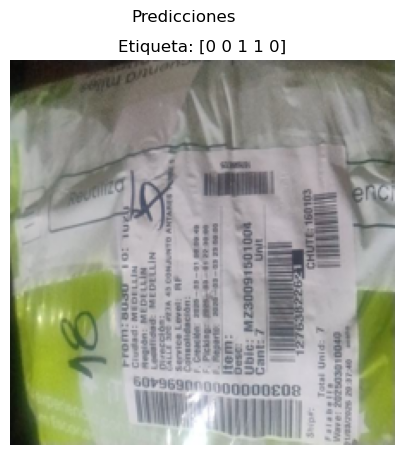

Etiquetas predichas: [[0 0 1 1 0]]


-->> Row 42: filename                 800129011406400224_2025030319262135.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 42, dtype: object
img_path: ./repo_validation\800129011406400224_2025030319262135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
42 : Predicciones (probabilidades): [[0.1483093  0.11969332 0.44754654 0.8086858  0.2679821 ]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


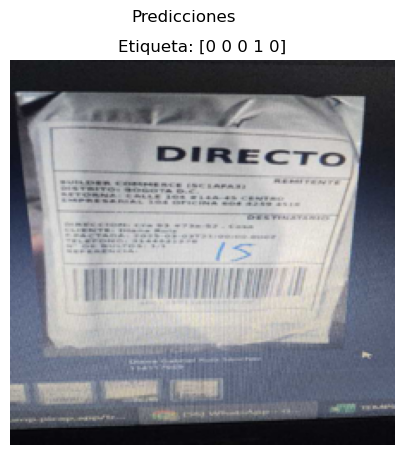

Etiquetas predichas: [[0 0 0 1 0]]


-->> Row 43: filename                 800129011406400224_2025030319262131.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 43, dtype: object
img_path: ./repo_validation\800129011406400224_2025030319262131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
43 : Predicciones (probabilidades): [[0.13468741 0.1214323  0.43976337 0.7750939  0.34120086]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


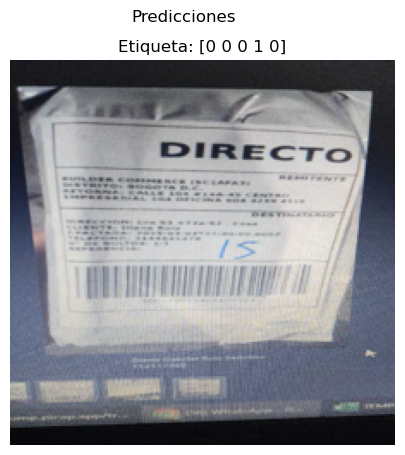

Etiquetas predichas: [[0 0 0 1 0]]


-->> Row 44: filename                 800129011406400224_2025030319262122.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 44, dtype: object
img_path: ./repo_validation\800129011406400224_2025030319262122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
44 : Predicciones (probabilidades): [[0.12499765 0.10901892 0.4989285  0.8124433  0.31611642]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


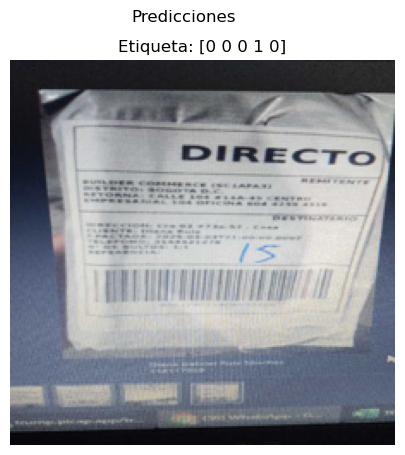

Etiquetas predichas: [[0 0 0 1 0]]


-->> Row 45: filename                 800129011413530273_2025030319254715.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 45, dtype: object
img_path: ./repo_validation\800129011413530273_2025030319254715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
45 : Predicciones (probabilidades): [[0.06622452 0.11449421 0.88254786 0.88166887 0.08676378]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


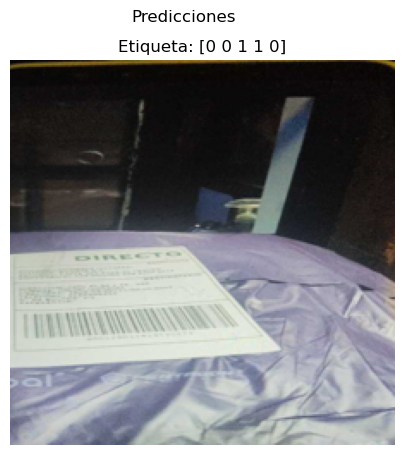

Etiquetas predichas: [[0 0 1 1 0]]


-->> Row 46: filename                 800129011413530273_2025030319254710.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 46, dtype: object
img_path: ./repo_validation\800129011413530273_2025030319254710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
46 : Predicciones (probabilidades): [[0.7389263  0.7180947  0.05663439 0.09258589 0.05233045]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


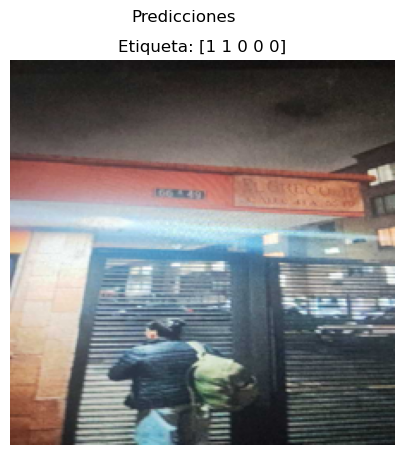

Etiquetas predichas: [[1 1 0 0 0]]


-->> Row 47: filename                 800129011413530273_2025030319254697.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 47, dtype: object
img_path: ./repo_validation\800129011413530273_2025030319254697.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
47 : Predicciones (probabilidades): [[0.1330093  0.14355133 0.51508266 0.8687888  0.06114366]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


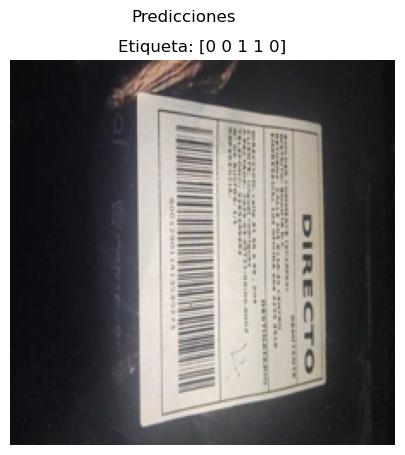

Etiquetas predichas: [[0 0 1 1 0]]


-->> Row 48: filename                 800129011391670040_2025030319205727.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 48, dtype: object
img_path: ./repo_validation\800129011391670040_2025030319205727.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
48 : Predicciones (probabilidades): [[0.92109495 0.444741   0.03668303 0.06491754 0.01494238]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


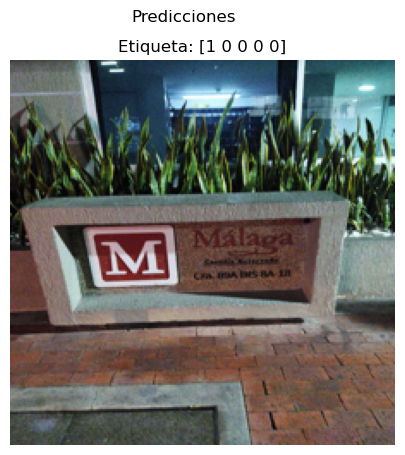

Etiquetas predichas: [[1 0 0 0 0]]


-->> Row 49: filename                 800129011391670040_2025030319205718.jpg
urlAbsoluta    https://stlogimasest2prod.blob.core.windows.ne...
Name: 49, dtype: object
img_path: ./repo_validation\800129011391670040_2025030319205718.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
49 : Predicciones (probabilidades): [[0.01685727 0.0116057  0.6376728  0.9898583  0.02445894]]
['direccion', 'fachada', 'envio', 'etiqueta', 'planilla']


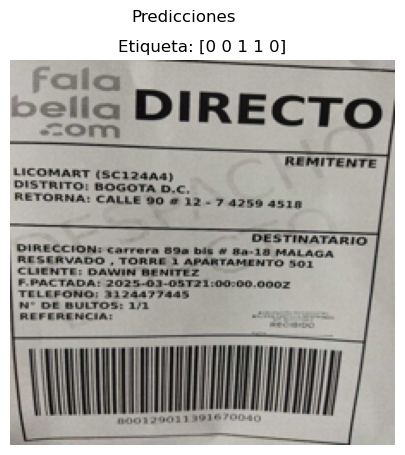

Etiquetas predichas: [[0 0 1 1 0]]




In [10]:
# 1. Cargar el modelo (agregando custom_objects si usas métricas personalizadas)

model = tf.keras.models.load_model(MODEL_NAME,
    custom_objects={
        'F1ScoreMacro': lambda **kwargs: F1ScoreMacro(num_classes=4, threshold=0.5, **kwargs),
        'F1ScoreMicro': lambda **kwargs: F1ScoreMicro(threshold=0.5, **kwargs)
    })


# 2. Función para cargar y preprocesar la imagen
# cargar las imagenes
def prepare_image(row, local_image_path, target_size=(224, 224)):
    try:
        # Cargar desde archivo local
        img_path = os.path.join(local_image_path, row['filename'])
        print(f"img_path: {img_path}")
        if os.path.exists(img_path):
            image = Image.open(img_path)
        elif pd.notna(row['urlAbsoluta']):    
             urlAbsoluta = row['urlAbsoluta']
             if 'http' in urlAbsoluta:
                 print(f"urlAbsoluta: {urlAbsoluta}")
                 # Descargar la imagen desde la URL
                 response = requests.get(row['urlAbsoluta'], stream=True, timeout=10)
                 if response.status_code == 200:
                     image = Image.open(BytesIO(response.content))
                     #guardar local para el siguiente ciclo de entrenamiento/prueba
                     image.save(img_path)
             elif os.path.exists(urlAbsoluta):
                 image = Image.open(urlAbsoluta)
             else:
                 raise Exception(f'Error cargando {urlAbsoluta}, archivo no encontrado')
    
        # Convertir a RGB (en caso de que la imagen esté en otro formato, como RGBA)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Redimensionar la imagen
        image = image.resize(target_size)  # Redimensionar a 224x224 para MobileNetV3
        
        # Convertir a un array de numpy y normalizar
        image = np.array(image) / 255.0  # Normalizar

        image = np.expand_dims(image, axis=0)
        return image
    except BaseException as e:
        print(f'Error en: {img_path}, Excepción: {str(e)}')
        return None


def visualize_images(images, labels, title, num_images=5):
    """
    Muestra un conjunto de imágenes con sus etiquetas asociadas.
    
    Args:
        images (np.array): Arreglo de imágenes (formato HWC, RGB).
        labels (np.array): Etiquetas asociadas a las imágenes.
        title (str): Título de la visualización.
        num_images (int): Número de imágenes a mostrar.
    """
    plt.figure(figsize=(15, 5))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        img = images[i]
        
        # Asegurar que la imagen esté en el rango [0, 255]
        if img.max() <= 1.0:
            img = img * 255.0
        img = img.astype("uint8")
        
        plt.imshow(img)
        plt.title(f"Etiqueta: {labels[i]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()



# 3. Cargar una imagen real (ruta a la imagen)
image_path = './repo_validation'  # Cambia a la ruta de la imagen que quieres probar
csv_validaton = './dataset_validacion_manual.csv'

df = pd.read_csv(csv_validaton)

for i in range(len(df)):
    print(f"-->> Row {i}: {df.iloc[i]}")
    img_array = prepare_image(df.iloc[i], local_image_path=image_path)

    if img_array is None:
        continue

    # 4. Realizar la predicción
    predictions = model.predict(img_array)
    print(str(i), ': Predicciones (probabilidades):', predictions)
    
    # 5. Aplicar un umbral para obtener etiquetas binarias (para multi-etiqueta)
    #threshold = 0.57  # dev set
    threshold = 0.5 # train set
    pred_labels = (predictions > threshold).astype(int)

    images = [img_array[0,...]];
    print(LABEL_COLUMNS)
    visualize_images(images, pred_labels, 'Predicciones', num_images=1)
    
    print('Etiquetas predichas:', pred_labels)
    print('')
    print('')

    if(i > 50):
        break